<font size=8>Dimensionality Reduction and Clustering</font>

In [11]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os, sys

%matplotlib inline
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "11_Unsupervised"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Dimensionality Reduction

Working in high-dimensional spaces is often unconvenient or even impossible. One might want to reduce the dimensionality in order to:
* Make visualizations
* Save storage space of the data (compression)
* Reduce computational costs of training algorithms, by reducing number of features.
* Increase a models performance by increasing the signal/noise ratio, as well as the density of points (*curse of dimensionality*).

The problem of reducing the dimensionality of features, while retaining most of the information, is called *dimensionality reduction* and there are two main approaches to it:
* Projection: Project the high-dimensional space into a hyper-plane, collapsing all the features orthogonal to it.
* Manifold-Learning: Learning the geometry of a lower-dimensional manifold, and projecting the data onto it.

On the first category, the most known algorithm is Principal Component Analysis.

## Principal Component Analysis

The aim of Principal Component Analysis is to find the direction onto which to project the data with minimum information loss.

We will see this in action, but first, let's take a more intuitive, naive approach to the problem by looking at a toy example.

### Naive approach to dimensionality reduction

We will create a ficticious dataset, $\{x^{(i)}\}$, of points in 2D, and suppose that for some reason we want to reduce the data to a single dimension. That is, each data instance $x^{(i)}$ is represented by two real number ($x^{(i)} \in \mathbb{R}^2$, in mathematical jargon), and we want to construct an approximate dataset in a one-dimensional space ($z^{(i)} \in \mathbb{R}$), i.e. each new instance $z^{(i)}$ will be represented by a single number. 

Of course, except in very specific situations (for example, $x_2 = 2 * x_1$) we will lose some information by doing this. The game consists in finding the way to choose this single number that reduces this information loss.

Let's start.

**Create a 2D dataset from an homogeneous normal distribution and rotate it**

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Create independent random Gaussian data (200 points)
m = 200
np.random.seed(3)
X_base = np.random.randn(m, 2) 

# Check dimension of resulting array (matrix)
print(X_base.shape)

(200, 2)


In [13]:
# Define angle by which to rotate and factor by which to stretch the data
angle = np.pi / 8
stretch = 5

# Stretch matrix
S = np.array([[stretch, 0],
              [0, 1]])

# Rotation matrix
R = np.array([[np.cos(angle), np.sin(angle)], 
              [-np.sin(angle), np.cos(angle)]])

# Stretch
X = X_base @ S
# Rotate
X = X @ R

Text(0, 0.5, '$X_2$')

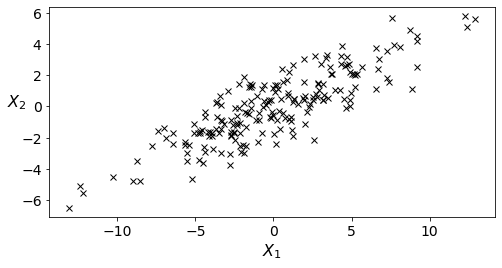

In [14]:
# Let's take a look at the resulting dataset 
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X.T, marker='x', color='k', ls='')
ax.set_aspect('equal')
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

Of course, these are just random numbers in 2D. Let us assume we have centred the data by removing the mean on each axis (that is why the data are centred at 0.0).

You may think of a couple of examples of datasets when this situation may exist:

* Height vs. Weight of a sample of people from a given population.
* Price of some good vs. demand for that good.

**Can you provide one or two additional examples?**

One way to reduce the dimensionality of this dataset would be simply to **remove one of the dimensions**. 

### Discarding one dimension

We can see the histograms of data projection in $x$ and $y$ 

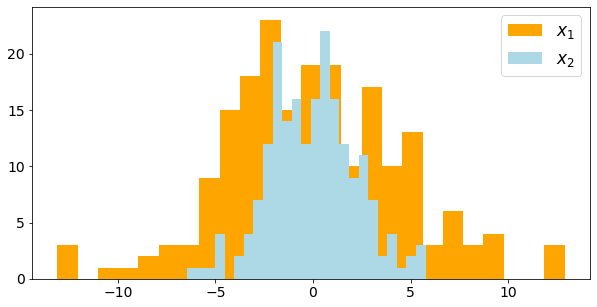

In [15]:
ax = plt.figure(figsize=(10, 5)).add_subplot(111)

ax.hist(X[:, 0], label='$x_1$', color='orange', bins=25)
ax.hist(X[:,1], label='$x_2$', color='lightblue', bins=25)
ax.legend(loc=0, fontsize=17)


However, the chosen direction is clearly **not the best**. 

**Can you draw the directions that you think would produce a better conservation of the data information? Why?**

### *Projection into the diagonals

Looking at the data it might make sense to **project on the diagonal directions**, and only keep one of them. There are two diagonals, so let's make the two projections and see which one works best.

In [16]:
variant_1 = X[:, 0] + X[:, 1] # x + y
variant_2 = X[:, 0] - X[:, 1] # x - y

Text(0, 0.5, '$X_2$')

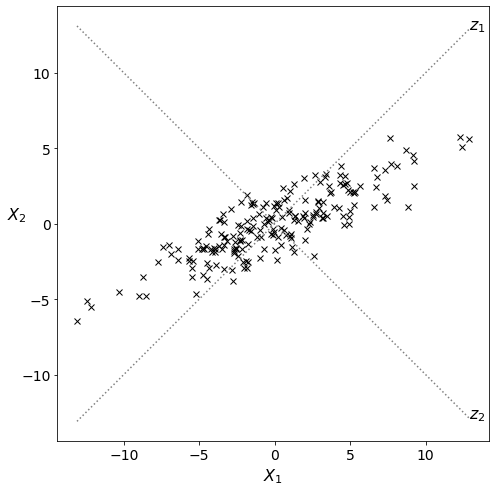

In [17]:
# Let's take a look at the resulting dataset 
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

imin = np.argmin(X[:, 0])
imax = np.argmax(X[:, 0])

ax.plot([X[imin, 0], X[imax, 0]], [X[imin, 0], X[imax, 0]], ls=':', color='gray')
ax.plot([X[imin, 0], X[imax, 0]], [-X[imin, 0], -X[imax, 0]], ls=':', color='gray')

# Annotate new axes
ax.annotate('$z_1$', [X[imax, 0], X[imax, 0]], fontsize=16)
ax.annotate('$z_2$', [X[imax, 0], -X[imax, 0]], fontsize=16)

# Uncomment these two lines to plot proyections
# ax.plot(0.5*variant_1, 0.5*variant_1, 'x', color='orange', ls='')
# ax.plot(0.5*variant_2, -0.5*variant_2, 'x', color='lightblue', ls='')

# Labels
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

Text(0.5, 0, '$z$')

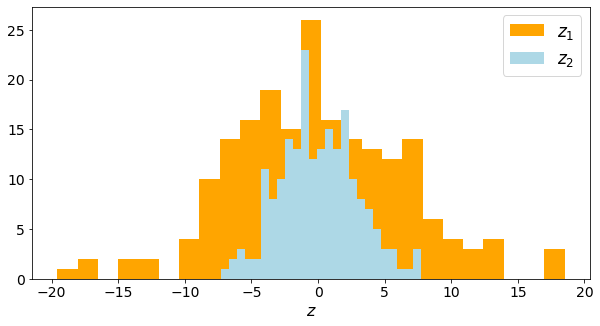

In [18]:
ax = plt.figure(figsize=(10, 5)).add_subplot(111)

ax.hist(variant_1, label='$z_1$', color='orange', bins=25)
ax.hist(variant_2, label='$z_2$', color='lightblue', bins=25)
ax.legend(loc=0, fontsize=17)

ax.set_xlabel('$z$', fontsize=16)

We see that there is one direction in which the data is more spread than the other one, and probably preserves more information. This would be a good candidate to choose $z$ from.

**Which one of the two options would you choose?**

### Runnning PCA

Actually, the main task of the PCA is to find the optimal set of axes onto which to project the available data. Each of the directions of these new axes are called Principal Components.

In PCA, this is quantified by the variance of the data. Therefore, the first Principal Component is the direction that preserves most of the variance of the data. Further directions are found (as many as dimensions in the dataset --i.e. number of features), on the condition that each succesive component will retain as much remaining variance (information) as possible, and be orthogonal with all the previous ones.

In other words, the algorithm fits an ellipsoid to the data, and then rotates the data axes so that they align with the ellipsoid's principal axes. The rotated axes are the principal components. For those of you who like linear algebra, this is equivalent to finding an orthogonal base in which the covariance matrix is diagonalised.

Let's see the implementation in `sklearn`.

In this case, we are dealing with a `Transformer` class (not to be confused with the popular Deep Learning models). In `sklearn`, these classes have a `.fit` method, that takes a dataset as argument, and learns some parameters from it. In this case, it learns the covariance matrix from the data and how to invert it. They also have a `transform` method, that uses the learnt parameters to perform some transformation on the dataset. In this case convert the original dataset to the reduced set.

Finally, the `fit_transform` method concatenates both steps.

It is important for PCA that the dataset is normalised. We will then another transformer we have already seen.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Instatiate scaler and scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the principal components (how many components do we want?)
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

**Explore the shape of the output. Does it make sense?**

In [20]:
print(X.shape, X_pca.shape)

(200, 2) (200, 1)


The coordinates of the axes chosen to project (i.e. the Principal Components) are stored in the `components_` attribute, row-wise.

In [21]:
pca.components_.shape

(1, 2)

**Let's see this directions in the plot above**

Text(0, 0.5, '$X_2$')

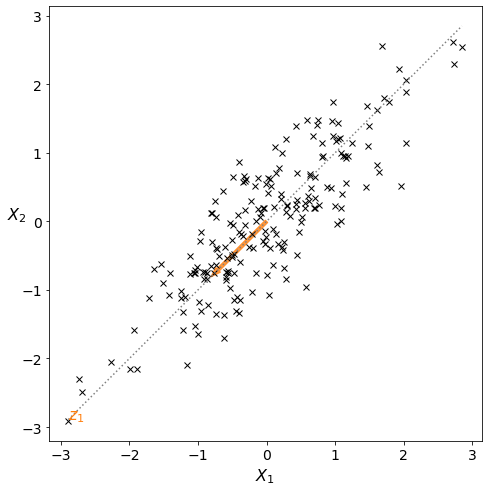

In [22]:
# Let's take a look at the resulting dataset 
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

z = pca.components_

for i in range(len(z)):
    #
    # slope of direction
    m = z[i, 0] / z[i, 1]
    
    # Plot line
    ax.plot([X_scaled[imin, 0], X_scaled[imax, 0]], 
            [X_scaled[imin, 0] * m, X_scaled[imax, 0] * m], 
            ls=':', color='gray')
    
    # Plot arrow
    size=1.0
    ax.arrow(0, 0, z[i, 0]*size, z[i,1]*size, color='C{}'.format(i+1), width=0.05, head_width=0.1, alpha=0.8,
             label='First PC')
    
    # Annotate new axes
    ax.annotate('$z_{}$'.format(i+1), [X_scaled[imin, 0], X_scaled[imin, 0]*m], fontsize=16, color='C{}'.format(i+1))

# Uncomment these lines to plot proyections onto the first PC (set zero on second component)
# X_pca_cut = X_pca.copy()
# X_pca_cut[:, 1] = 0
# X_1 = pca.inverse_transform(X_pca_cut)
# ax.plot(*X_1.T, 'x', color='orange', ls='')

# Labels
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

### *A bit of algebra

Let's compute (numerically) the covariance matrix of the original (scaled) data

Now, let's look at the covariance matrix of the transformed coordinates, this is what it looks like

In [23]:
# Find the principal components (how many components do we want?)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(np.cov(X_pca.T).round(2))

[[ 1.86 -0.  ]
 [-0.    0.15]]


Note two things:
1. the covariance matrix is now diagonal.
2. that most of the variance is located in the first coordinate. (N.B.: PCA automatically orders the features by its variance).

### Data in the transformed axes

Text(0, 0.5, '$z_2$')

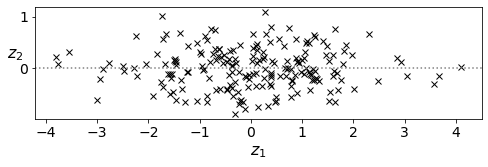

In [24]:
# In the transformed axis, the data look like an aligned elipsoid
ax = plt.figure(figsize=(8, 8)).add_subplot(111)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
ax.plot(*X_pca.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

ax.axhline(0.0, color='gray', ls=':')

# Labels
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)

**Question**. Going back to the use examples from above (height vs. weight, ...), can you say what each new coordinate $z$ represent?

We can easily go back to the original space using the `inverse_transform` method. **Complete the code below with the right input for this method**. Note that the code check if the reconstruction was done correctly.

In [25]:
X_reconstructed = pca.inverse_transform(X_pca)

print('Is the reconstruction perfect? {}'.format('Yes' if np.allclose(X_scaled, X_reconstructed) else 'No'))

Is the reconstruction perfect? Yes


**Question**. Did we lose any information by going to the PCA space and back? Did we reduced the dimensionality of the dataset?

### Incomplete reconstruction

Going to the PCA space and back is not a reduction dimensionality task, and therefore does produce any information loss. Let's see what happens if we only keep the projection of the data onto the first principal component.

In [26]:
# Run PCA with a single component
pca = PCA(n_components=1)
X_pca_1D = pca.fit_transform(X_scaled)

If we do the inverse transform, some information was lost, and so the inverted data is not the same as the original:

In [27]:
X_reconstructed = pca.inverse_transform(X_pca_1D)
print('Is the reconstruction perfect? {}'.format('Yes' if np.allclose(X_scaled, X_reconstructed) else 'No'))

Is the reconstruction perfect? No


Let's take a look at this compressed data, and how it looks like:

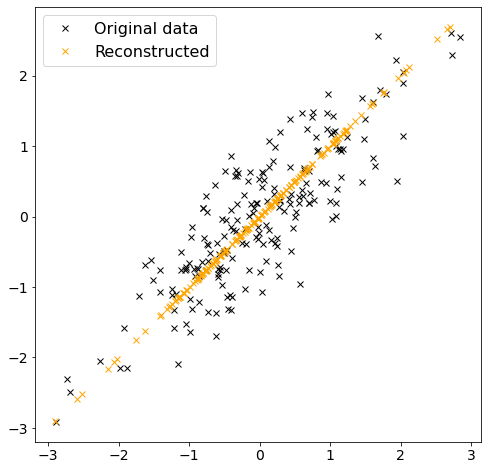

In [28]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='', label='Original data')
ax.plot(*X_reconstructed.T, marker='x', color='orange', ls='', label='Reconstructed')
ax.legend(fontsize=16)
ax.set_aspect('equal')

This is exactly the projection on the direction given by the first principal component. In this way, the resulting compressed dataset retains the maximum possible variance. 

If we look at the covariance matrix, we see that not much was lost:

In [29]:
print('Original covariance matrix\n', np.cov(X_scaled.T))
print('\nCompressed covariance matrix\n', np.cov(X_reconstructed.T))

Original covariance matrix
 [[1.00502513 0.85070879]
 [0.85070879 1.00502513]]

Compressed covariance matrix
 [[0.92786696 0.92786696]
 [0.92786696 0.92786696]]


The fraction of the total variance (information) kept by each principal component is stored in the `explained variance_ratio_` attribute:

In [30]:
pca.explained_variance_ratio_

array([0.92322762])

This shows that the projecting in the direction of the first PC retains over 92% of the data variance, while reducing the data dimension why half!

### *An example in 4D (the Iris dataset)

In order to reduce dimensionality, we can chose to keep the first `n` principal components of our data. This way, we make sure that we're throwing away the components that carry the least information (as measured by the variance).

If we want to keep a fixed number of components, we can just set the `n_components` parameter of scikit-learn's `PCA` class. 

Let's use the Iris dataset. This famous dataset (it has its own [wikipedia page](https://en.wikipedia.org/wiki/Iris_flower_data_set)!) consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, this dataset is used to learn to classify species. But here we will use it simply to show how PCA works in many dimensions.

In [31]:
from sklearn.datasets import load_iris

data = load_iris()
X, t = data['data'], data['target']
names = data['feature_names']

Before transforming the data, lets plot every pair of features:

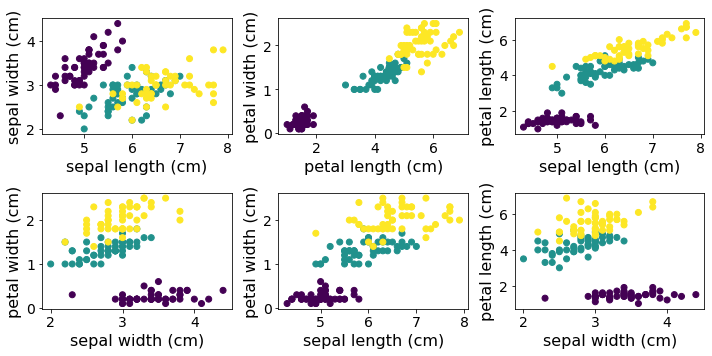

In [32]:
fig, axs = plt.subplots(2,3)

for ax,(i,j) in zip(axs.flatten(),[(0,1),(2,3),(0,2),(1,3),(0,3), (1,2)]):
    ax.scatter(X[:,i], X[:,j],c=t,)
    ax.set_xlabel(names[i])
    ax.set_ylabel(names[j])
    
fig.set_size_inches(10,5)
fig.tight_layout()
plt.show()

Let's reduce our data to just two dimensions. **Complete the code below**

In [33]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [34]:
print(X.shape, X2D.shape)

(150, 4) (150, 2)


We can use the fact that we are only retaining two dimensions to plot the _entire_ tranformed dataset. **Note**: the colors are given by use, just to keep track of the Iris classes, but the PCA algorithm is completely agnostic to this.

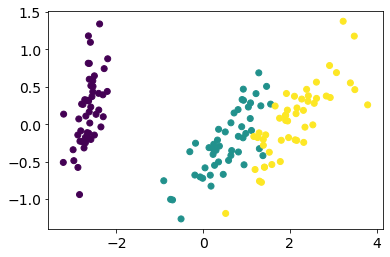

In [35]:
plt.scatter(*X2D.T, c=t)

In [36]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

We see that now the data looks the most separated in the fist diretion, which keeps over 92% of the data variance!

We can inverse the transformation, but as before, some information was lost in the projection:

In [37]:
X4D_inv = pca.inverse_transform(X2D)
print('Is the reconstruction perfect? {}'.format('Yes' if np.allclose(X, X4D_inv) else 'No'))

Is the reconstruction perfect? No


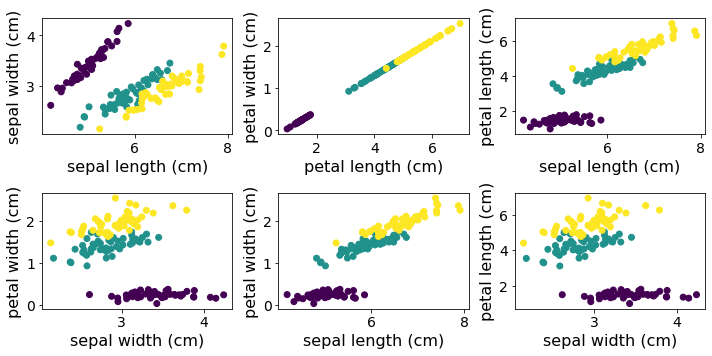

In [38]:
# Let us plot the four features after reconstruction. Compare this with the first plot in this section.
fig, axs = plt.subplots(2,3)

for ax,(i,j) in zip(axs.flatten(),[(0,1),(2,3),(0,2),(1,3),(0,3), (1,2)]):
    ax.scatter(X4D_inv[:,i], X4D_inv[:,j],c=t,)
    ax.set_xlabel(names[i])
    ax.set_ylabel(names[j])
    
fig.set_size_inches(10,5)
fig.tight_layout()
plt.show()

A measure of how much is lost is the *reconstruction error*:

In [39]:
np.mean(np.sum(np.square(X4D_inv - X), axis=1))

0.101364295729593

### Application on a high-dimensional dataset

Finding an optimal lower-dimensional representation of our data, allows us to store it using less space and reconstruct it loosing as little information as possible. Let's see how this works with images:

In [40]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_mnist = mnist["data"]/255.0 # notice the normalisation
t_mnist = mnist["target"]

In [41]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

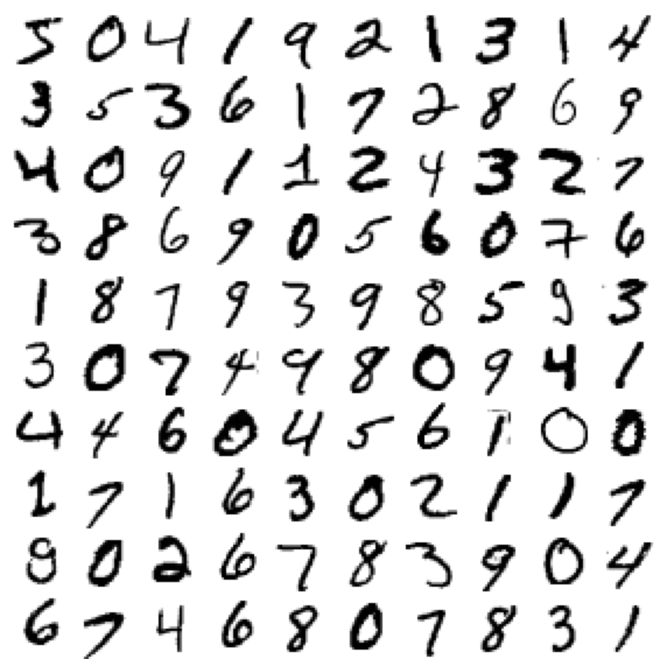

In [42]:
fig =  plt.figure(figsize=(12,12))
plot_digits(X_mnist[:100], 10)

Each digit consits on 784 pixels. Let's see how the reconstructed images when we use PCA to store it as a lower-dimensional vector.

**Complete the code below with a resonable number for the number of components**

In [43]:
pca = PCA(n_components=150)

X_reduced = pca.fit_transform(X_mnist)
X_recovered = pca.inverse_transform(X_reduced)

In [44]:
print(X_mnist.shape, X_reduced.shape, X_recovered.shape)

(70000, 784) (70000, 150) (70000, 784)


Text(0.5, 1.0, 'Compressed')

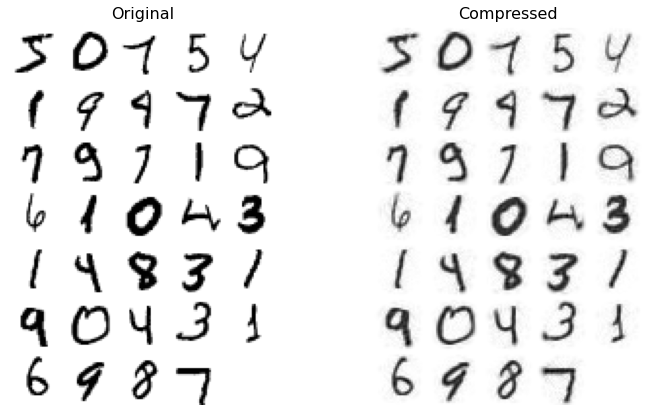

In [45]:
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(np.abs(X_recovered[::2100]))
plt.title("Compressed", fontsize=16)

If we're not sure about what dimensionality should we impose, we can plot the cumulative sum of the explained variance ratio to see how much information is lost. If all features are used, it should be 1

In [46]:
pca = PCA()
pca.fit(X_mnist) #fit without reducing dimensionality

PCA()

In [47]:
# See the first elements of the explaned variance
print(pca.explained_variance_ratio_[-10:])

[3.51357715e-34 3.51357715e-34 3.51357715e-34 3.45777578e-34
 1.98328497e-34 1.30362240e-34 1.28766022e-34 1.09580166e-34
 9.50211830e-35 4.75139353e-35]


**Question**. Compare and contrast with the cases above (Iris dataset and simulated set). What do you see?

It is interesting to see how many components we need to keep to preserve a given variance level. For example, 95%. To do this, we can compute the *cumulative sum* of the explained variance ratios.

With 154 dimensions, we preserve 0.95 of the variance.


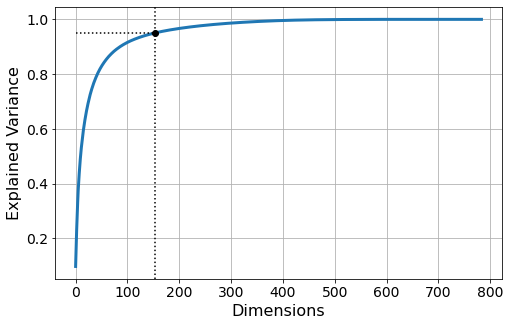

In [48]:
# Define what fraction of the variance you wish to keep
var_frac = 0.95

# Compute the cumulative sum and plot it
cumsum = np.cumsum(pca.explained_variance_ratio_) 
#this tells us how much information is retained if we stop at each dimension

# At what moment does the cumulative zoom reach var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('With {} dimensions, we preserve {} of the variance.'.format(d, var_frac))

plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])

plt.axvline(d, color="k", ls=":")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.xlabel("Dimensions", fontsize=16)
plt.ylabel("Explained Variance", fontsize=16)

plt.grid(True)

### Visualizing PCs

Although the task we are dealing with here is dimensionality reduction, the directions given by the principal components can also be thought of as individual instances in the data space, therefore corresponding to one 28 x 28 pixel image each.

One may wonder how do the first few PCs look like for this dataset. 

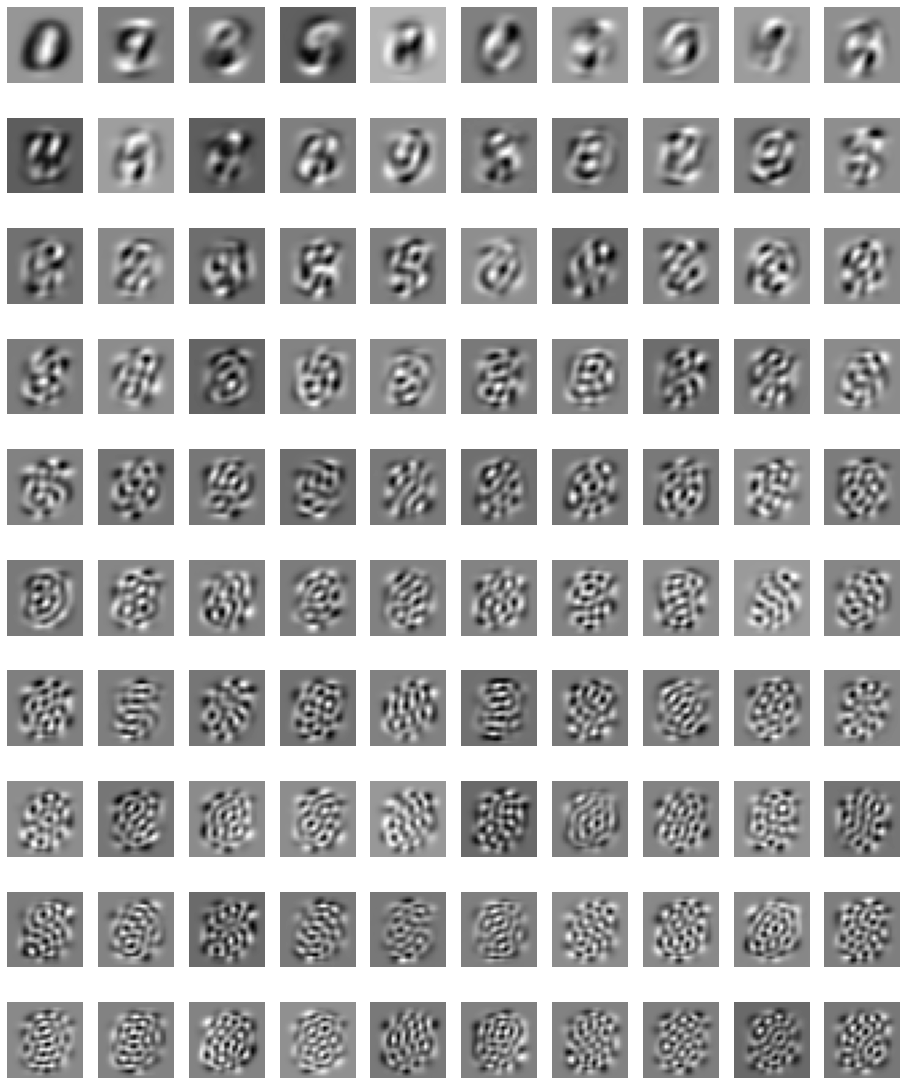

In [49]:
npc = 100

ncolumns = 10
nrows = npc // ncolumns

# Add extra row, if necessary
if npc % ncolumns:
    nrows += 1

fig, axs = plt.subplots(nrows, ncolumns, figsize=(16, 2*nrows))

for i, ax in zip(range(npc), axs.flatten()):
    pci_reshaped = pca.components_[i].reshape(28,28)
    ax.imshow(pci_reshaped, cmap='gray_r')
    ax.axis('off')

**Question.** Do you see anything worth mentioning from these figures?

Note how the type of image change as we move from the first few PCs to the high-order ones. What do you think this means?

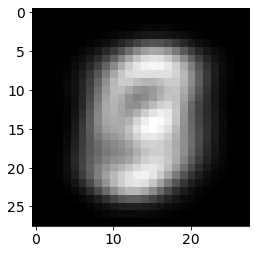

In [50]:
# We can also plot the mean
plt.imshow(pca.mean_.reshape(28, 28), cmap='gray')

We can see the first 11 principal components of PCA for 4 different digits

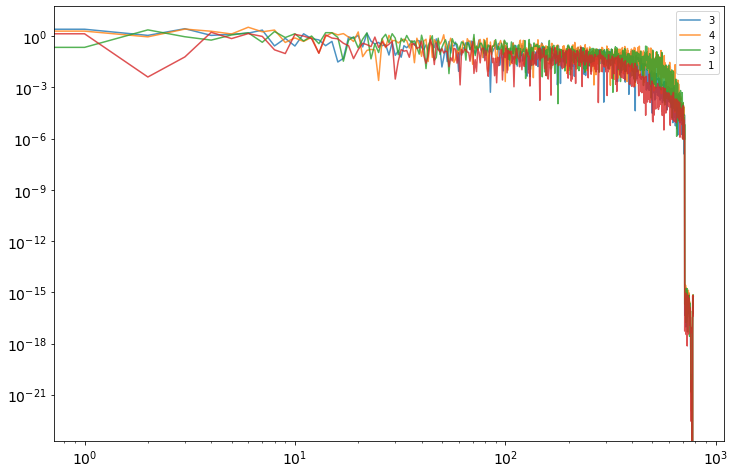

In [51]:
fig = plt.figure(figsize=(12,8))

for i in [10, 20, 30, 40]:
    # Plot coefficients of components
    plt.loglog(np.abs(pca.transform(X_mnist[i].reshape(1, -1))).flatten(), 
               label=t_mnist[i], alpha=0.8)
    
    # Plot the original pixels
    # plt.plot(np.abs((X_mnist[i].reshape(1, -1))).flatten(), 
    #         label=t_mnist[i], alpha=0.4)
# plt.xlim(0, 10)
plt.legend(loc=0)

In [52]:
X_mnist.shape

(70000, 784)

## *Kernel PCA

A variant of PCA used to learn non-linear mappings is called *kernel-PCA*, which makes use of the *kernel trick* to map the original features into a higher-dimensional (maybe infinite-dimensional) space, in which PCA is applied. This is useful to learn more complex non-linear transformations.

**Note**. Kernel methods are taught in the second course on **Advanced topics**. Please join us if you want to know how these techniques work.

Kernel PCA has the **strong** disadvantage that the inverse transformation is not easy to obtain.
We invite you to explore this algorithm and experiment with the different hyperparameters:

* n_components
* kernel. Choose what kernel is used to perform the mapping to a high dimensional space. You may try: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’} 
* gamma. Length scale for 'rbf' kernel
* degree. Polynomial degree for 'poly' kernel

In [53]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)

### Iris Dataset

In [54]:
X_kpca = rbf_pca.fit_transform(X)

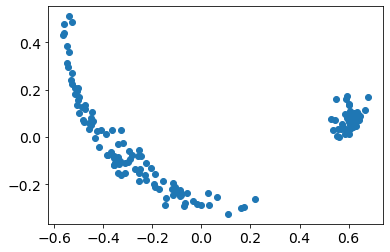

In [55]:
plt.scatter(*X_kpca.T)

Looks funny, let's see how it behaves with a more complex dataset:

### Swiss Roll

In [56]:
from sklearn.datasets import make_swiss_roll

X, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

This dataset is a rolled plane, which is harder to decompose

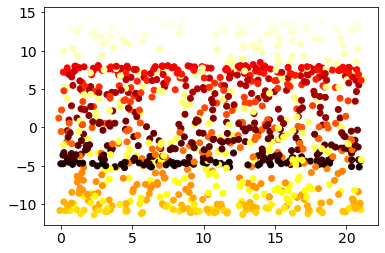

In [57]:
plt.scatter(X[:, 1], X[:, 2], c=z,  cmap=plt.cm.hot)

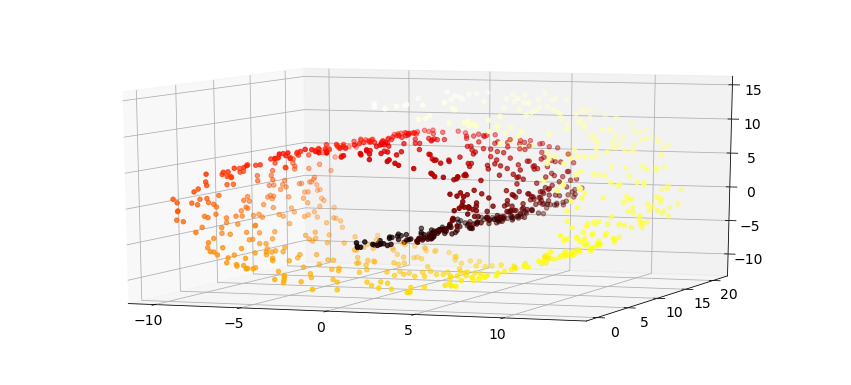

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Let's compare the results of different kernels

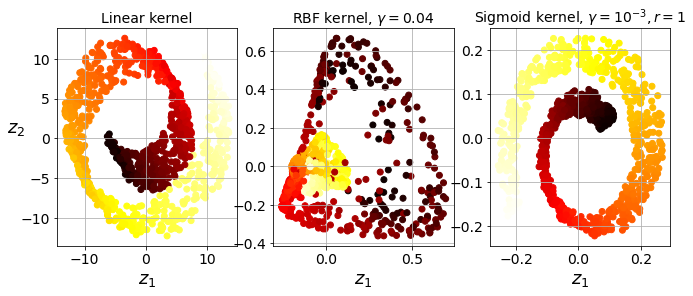

In [59]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) #equivalent to PCA(n_components=2)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Manifold Learning

Manifold learning is used to discover non-linear patterns in the data. 

To explore this, we will use the Swiss roll data.

In [60]:
from sklearn.datasets import make_swiss_roll

X_sr, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

This dataset is a rolled plane, which is harder to decompose

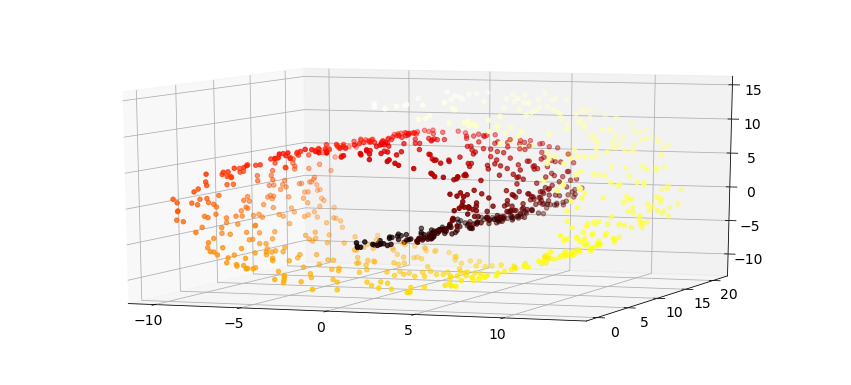

In [61]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X_sr[:, 0], X_sr[:, 1], X_sr[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Of course, the optimal projection for the Swiss roll would be something that _unrolls_ the data, so that it looks like this:

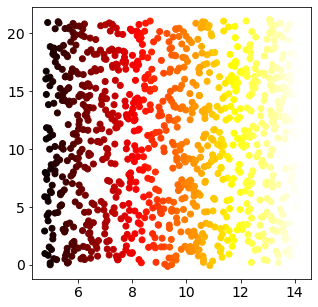

In [62]:
plt.figure(figsize=(5,5))
plt.scatter(z, X_sr[:,1], c=z,  cmap=plt.cm.hot)

Learning such kind of subspaces, which are embedded into a higher dimensional space, is called *Manifold Learning*. 

### Local Linear Embedding

A simple method, which we'll not cover in detail, is the *Locally Linear Embedding* (LLE). 

LLE works by fitting a hyperplane in `n_components` dimension to the `n_neighbors` points of each instance. Then, it projects the datapoints to these fitted subspaces. Let's see how it works on the Swiss roll.

As always, we instantiate the object with some hyperparameters, and use the method `fit_transform`

In [63]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X_sr)

In [64]:
# Check the dimensions of what we found.
print(X_sr.shape, X_reduced.shape)

(1000, 3) (1000, 2)


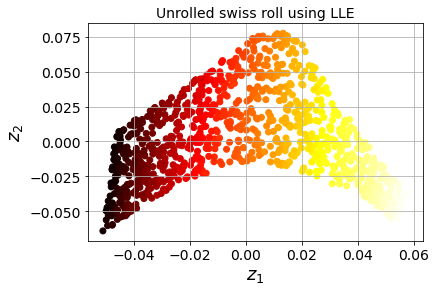

In [65]:
# Plot the results
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

It is not bad, but not optimal either. 

**Task**. Experiment with the `n_neighbors` hyperparameter. Do you find better results? Dive into the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) and see if you can find something else to tweak.

### tSNE

A popular manifold learning technique used for visualizations is the *t-Distributed Stochastic Neighbor Embedding* or tSNE. This technique learns a non-linear mapping that tends to group similar instances toghether, while distancing disimilar instances appart,

We will try it on the MNIST dataset. Notice how simply it is to use it, as always: instantiate, fit_transform, enjoy!

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_mnist[:1000])#fit a subset to reduce computing time

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [67]:
t_mnist.shape

(70000,)

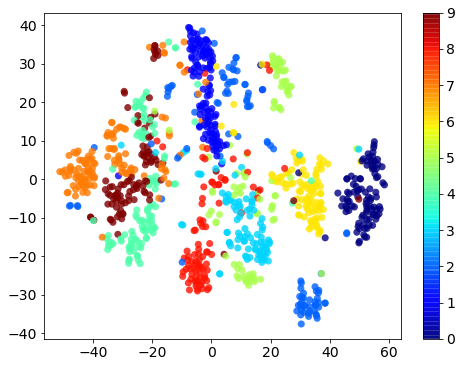

In [68]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scat = ax.scatter(*X_reduced_tsne.T, c=t_mnist[:1000], s=50, cmap='jet', 
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat)

Look! The numbers have clustered in some cases, even if the algorithm is completely ignorant of the labels (which we have used to colour the points!). Amazing!

Now let's try this in 3D

In [69]:
tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne_3d = tsne.fit_transform(X_mnist[:1000])#fit a subset to reduce computing time

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


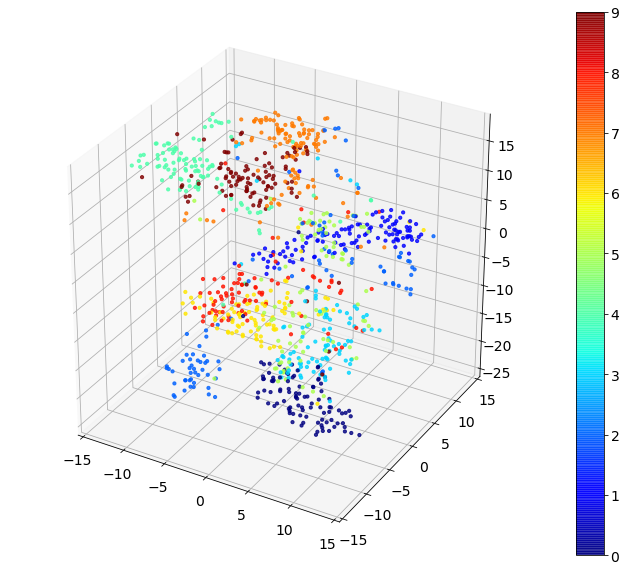

In [70]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(*X_reduced_tsne_3d.T, c=t_mnist[:1000], s=10, cmap='jet', 
                   alpha=0.8)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
fig.colorbar(scat)

**Let's discuss about this plot.** 

A script to obtain an interactive version is available in the repository.

Usage:

```
python3 -i PATH-TO-REPO/scripts/tSNE_MNIST.py
```

# Play time! Eigenfaces

We invite you to build a Face Recognizer using PCA:

* Use PCA to project the dataset in the N principal components (try N=150 for example)
* Plot the image corresponding to the first few (20? 30?) principal components (an *eigenface*)

**BonusTrack**: Use K-means to cluster the data (in PCA-processed version). Plot different clusters to see if it manages to distinguish each person.

In [71]:
# Read data
from sklearn import datasets

lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [72]:
X = lfw_people.data

# Number of features
n_features = X.shape[1]

# The label to predict is the id of the person
t = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('A dataset with {} instances of {} features and {} classes.'.format(len(X), n_features, n_classes))

A dataset with 1288 instances of 1850 features and 7 classes.


In [73]:
# Who are these people?
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [75]:
#print(np.t.unique())


In [76]:
# Is the dataset balanced?
for i in range(len(target_names)):
    print(target_names[i],':',sum(t == i))

Ariel Sharon : 77
Colin Powell : 236
Donald Rumsfeld : 121
George W Bush : 530
Gerhard Schroeder : 109
Hugo Chavez : 71
Tony Blair : 144


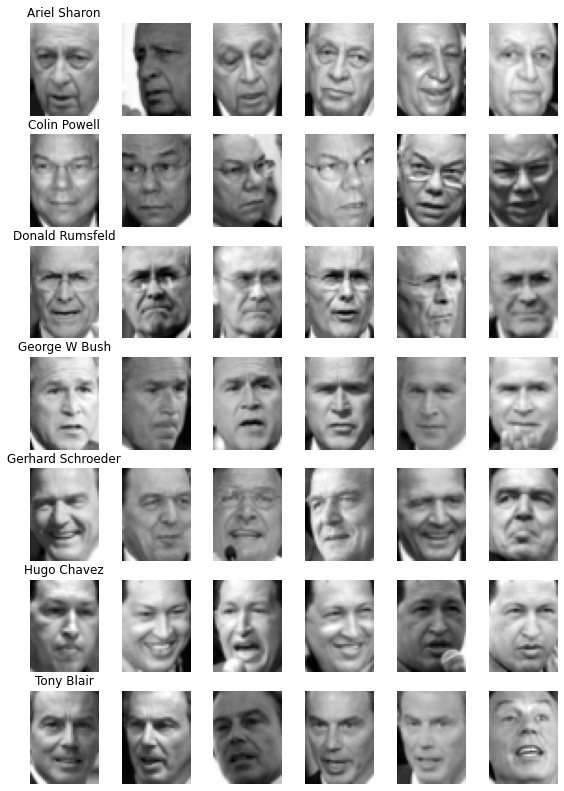

In [77]:
#lets plot a few of examples
n_pics_per_person = 6

n_cols = n_pics_per_person
n_rows = len(target_names)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.6*n_cols, 2*n_rows))

for i in range(len(target_names)):
    # Select instances of that class
    Xi = X[t == i]
    # Randomly select n_pics_per_person
    idj = np.random.choice(len(Xi), size=n_pics_per_person, replace=False)
    
    for j, jj in enumerate(idj):
        axs[i, j].imshow(Xi[jj].reshape(50, 37), cmap='gray')
        axs[i, j].axis('off')
    axs[i, 0].set_title(target_names[i])

In [78]:
from sklearn.model_selection import train_test_split
# Train-test split
X_train, X_test, t_train, t_test = train_test_split(X, t, random_state=42)

In [79]:
X_train.shape

(966, 1850)

## Run PCA on this dataset

In [ ]:
pca = PCA()
pca.fit(X_train)

In [ ]:
print(len(pca.components_))

Note that here we have as many components as instances, not as features. If we don't specify, PCA takes the minimum between number of features and number of instances.

In [ ]:
print(pca.components_.shape)

Principal Components live in data space. They can therefore be visualised. Let us see the first few (more important) PCs, together with the data mean.
Remember that each principal component lives in original space (i.e. 1850 features)

In [ ]:
n_eigenfaces = 100
n_cols = 7

n_rows = (n_eigenfaces + 1) // n_cols
if (n_eigenfaces + 1) % n_cols:
    n_rows += 1

# Prepare grid of subplot
fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.6*n_cols, 2*n_rows))

# Remove axes for all
for ax in axs.flatten():
    ax.set_axis_off()

# plot mean face
_ = axs.flatten()[0].imshow(pca.mean_.reshape(50, 37), cmap='gray')
_ = axs.flatten()[0].set_title('Mean')

# plot eigenfaces
for i, ax in zip(range(n_eigenfaces), axs.flatten()[1:]):
    eigenface = pca.components_[i]
    _ = ax.imshow(eigenface.reshape(50,37), cmap = plt.cm.gray)
    _ = ax.set_title('PC{}'.format(i+1))

Now let us explore how much variance is explained? Let's see the first 10 elements.

In [ ]:
pca.explained_variance_ratio_[: 10]

Quite impressive! The first two PCs explain over 34% of the images variabilities. This is much better than the MNIST dataset

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_) #this tells us how much information is retained if we stop at each dimension

As above we can set a threhold of how much variance we want to retain, and use it to estimate the number of dimensions

In [ ]:
d = np.argmax(cumsum >= 0.95) + 1
print(d)

With 135 dimensions, we preserve 95% of the variance

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])

plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.grid(True)
plt.show()

## Reconstructing me softly

It is interesting to see how an image is recovered progressively as we add more and more PCs to the reconstruction.

In [ ]:
idx = 45
plt.imshow(X_train[idx].reshape(50, 37), cmap='gray')

In [ ]:
# Let us compute the coefficients for this specific image
coef = pca.transform([X_train[idx],])
print(coef.shape, pca.components_.shape)

In [ ]:
# Compute elements corresponding to each PC
partial = coef.T * pca.components_ 

# Build cumulative reconstructions
cpartial = np.cumsum(partial, axis=0)

Each element in `cpartial` then has the reconstruction with an increasing number of PCs (except for the mean).

Let's see this at work.

In [ ]:
# Maximum number of PCs to use in reconstruction
max_summed_elements = 350

# Thin factor, plot one reconstruction every `thin`
thin = 20

# Plotting definitions (n_columns, n_rows, etc)
n_images = max_summed_elements // thin + 2 # sum two for mean and original
n_cols = 7

n_rows = n_images // n_cols
if n_images % n_cols:
    n_rows += 1

# Prepare grid of subplot
fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.6*n_cols, 2*n_rows))
for ax in axs.flatten():
    ax.set_axis_off()

# plot eigenfaces
for i, ax in zip(range(n_images), axs.flatten()):
    if i == 0:
        # Plot mean as first reconstruction
        reconstruction = pca.mean_.reshape(50, 37)
    else:    
        reconstruction = cpartial[i*thin]
    ax.imshow(reconstruction.reshape(50,37) + pca.mean_.reshape(50, 37), cmap = plt.cm.gray)
    ax.set_title('{} PCs'.format(i*thin))

axs.flatten()[i+1].imshow(X_train[idx].reshape(50, 37), cmap='gray')
axs.flatten()[i+1].set_title('Original')

In agreement with what we saw above, most of the information of the original image is recovered using ~140 PCs.

# Clustering

The second most used unsupervised task, after Dimensionality Reduction, is probably clustering. The objective is to divide the dataset into a number of groups (*clusters*), with a rule to assign new instances a given *affinity* to each group. This is extremely useful in a number of settings:

* For customer segmentation
* For data analysis
* As a dimensionality reduction technique
* For anomaly detection (also called outlier detection)
* For semi-supervised learning
* For search engines
* To segment an image

## K-means

Let's introduce some mock data, which we'll try to cluster together:

In [80]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])


X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=42)

In [81]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

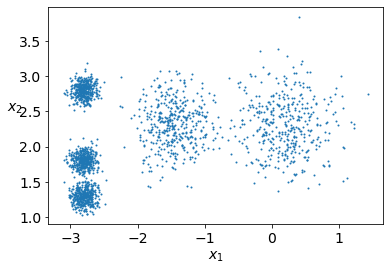

In [82]:
plot_clusters(X)

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2)

The K-means algorithm consists on:
1. Pick random centroids of the clusters
2. Label the data according to the closest centroid (the distance to each centroid plays the role of *affinity*)
3. Compute new centroids as the mean position of all the instances having the same label
4. Repeat steps 2 and 3 until the centroids position stop changing
The algorithm is guaranteed to converge in a finite amount of steps.

In [84]:
from sklearn.cluster import KMeans

#the number of clusters has to be set beforehand
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=5, random_state=42)

The labels assigned to each training instance is stored in the attribute `label_`

In [85]:
kmeans.labels_

array([2, 3, 2, ..., 0, 2, 3], dtype=int32)

In [87]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4], dtype=int32)

And assignation to labels of new samples is done through the `predict` method

In [88]:
y_train = kmeans.predict(X_train)

(y_train == kmeans.labels_).all()

True

In [93]:
y_train = kmeans.predict(X_train)
print(y_train)

[2 3 2 ... 0 2 3]


We can also recover the centers of the clusters with the `clusters_centers_` attribute. Each cluster center has two coordinates (in this example!)

In [89]:
print('__Coordinates of cluster centers__')
print(kmeans.cluster_centers_)

__Coordinates of cluster centers__
[[ 0.20916019  2.31457469]
 [-1.44774557  2.30564315]
 [-2.80622283  1.80775622]
 [-2.79899857  2.80290177]
 [-2.79206583  1.29586236]]


The distance of each data point to the center of each cluster can be computed using the `transform` method of the `KMeans` class. In this case, the algorithm is used as a pre-processing step. Don't get mixed up!

In [90]:
print('__Distances to cluster centers__')
print(kmeans.transform(X_train[:10]))

__Distances to cluster centers__
[[3.13847556 1.56008311 0.18466758 1.17490607 0.33902921]
 [3.2849022  1.65744375 0.95765944 0.25911475 1.46105201]
 [3.10773865 1.46610243 0.21553297 0.79843357 0.71893138]
 [3.16404088 1.53080689 0.86960207 0.19180846 1.37932887]
 [1.76110957 0.10418048 1.3491474  1.34291932 1.59864261]
 [3.09599974 1.4888541  1.01115393 0.04904186 1.52322176]
 [0.37153105 1.31841702 2.69584814 2.73602621 2.79848984]
 [1.66673918 0.10408955 1.47926477 1.40051567 1.740185  ]
 [3.07522364 1.48229768 1.0748708  0.08094903 1.5868824 ]
 [2.84714821 1.23903929 0.96301548 0.20163496 1.46560385]]


Let's plot the regions, as well as the centroids:

In [95]:
def plot_data(X, marker='.', color='k', ls='', markersize=2, **kwargs):
    plt.plot(X[:, 0], X[:, 1], marker=marker, ls=ls, color=color, markersize=markersize,
         **kwargs)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X, markersize=2)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

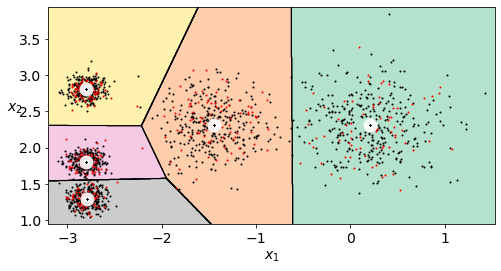

In [96]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X_train)
plot_data(X_test, marker='.', color='r')
plt.show()

We can see how many iterations it took the algorithm to converge:

In [97]:
kmeans.n_iter_

3

Nevertheless is quite unstable, and depends on the random seed:

n_init inicializa varias veces el algoritmo y evalua cual es el mejor resultado. (protege de caer en un minimo local)


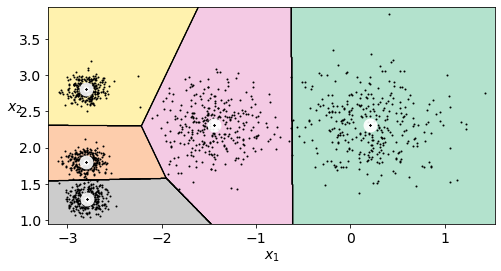

In [105]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
kmeans.fit(X_train)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X_train)
plt.show()

To surpass this, the algorithm runs on many different random seeds (setted by `n_init`), and uses the *best* final value, where *best* is measured as the *inertia*: The mean squared distance of each instance to its closest centroid.

In [110]:
kmeans.inertia_

171.29066380491332

In [111]:
kmeans.n_iter_

3

We can compute (the negative of) the inertia on a given dataset, by using the `score` method.

Se puede usar en conjuntos que no se usaron para entrenar

In [112]:
kmeans.score(X_train)

-171.29066380491338

### Optimal number of clusters

Similar to what we did in Dimensionality Reduction to find the number of principal components, one may ask what is the optimal number of clusters for a given dataset. One option is to choose look at the improvement as measured by the Inertia:

In [113]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

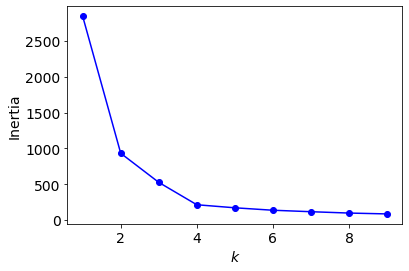

In [114]:
plt.plot(range(1, 10), inertias, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

We can see again a characteristic elbow, which might indicate that 4/5 could be a good number of clusters

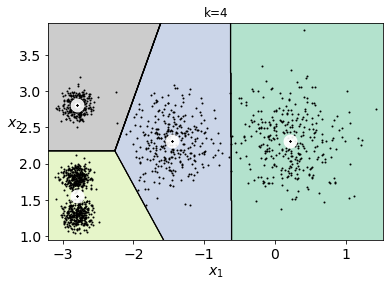

In [116]:
plot_decision_boundaries(kmeans_per_k[4-1], X_train)
plt.title('k=4')
plt.show()

Another approach is to look at the *silhouette score*, which is the mean silhouette coefficient over all the instances. 

An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and $b$ is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). 

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

This score is implemented in the metrics module of scikit-learn

In [117]:
from sklearn.metrics import silhouette_score

silhouette_score(X_train, kmeans.labels_)

0.6562507331886223

Let's use it to find the optimal number of clusters:

In [118]:

silhouette_scores = [silhouette_score(X_train, model.labels_)
                     for model in kmeans_per_k[1:]]

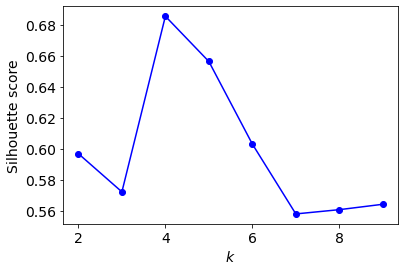

In [119]:
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

Effectively, 4 seems to be the optimal number of clusters for the dataset in question.

# Your turn!

1. Use the functions defined above to plot the clustering of the artificial datapoints for different numbers of clusters. This is made to help you gain intuition about how the algorithm works?

2. We have already presented three multidimensional datasets:
    * The California Housing dataset.
    * The MNIST handwritten digits dataset.
    * The portraits of international ~~autocrats~~ world leaders.

Choose one of them and apply KMeans with a reasonable number of clusters. Note that these are all labelled datasets (well, maybe not California...). The game here is to suppose you're not given the labels.

**Note**: if you use the California Housing dataset, we advise you to use the preprocessed version we keep in the repository (`/datasets/housing_pp_{train|test}`). Use the cell above to read it.

In [122]:
if 'google.colab' in sys.modules:
        
    DOWNLOAD_ROOT = "https://github.com/IAI-UNSAM/datasets/raw/master/"
    HOUSING_URL_BASE = DOWNLOAD_ROOT + "housing/housing_pp"

    HOUSING_PATH = './datasets'
    !mkdir -p ./datasets

    def fetch_housing_data(housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        #urllib.request.urlretrieve(housing_url, tgz_path)
        for t in ['train', 'test']:
            HOUSING_URL = HOUSING_URL_BASE+'_{}.csv'.format(t)
            !wget {HOUSING_URL} -P {housing_path}

    # Corramos la función
    fetch_housing_data()

else: 
    print("Not running on Google Colab.")

# Now you can read the California dataset straight from the datasets folder
import pandas as pd

housing_train = pd.read_csv('datasets/housing_pp_train.csv')
housing_test = pd.read_csv('datasets/housing_pp_test.csv')

--2022-03-22 22:48:41--  https://github.com/IAI-UNSAM/datasets/raw/master/housing/housing_pp_train.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/housing/housing_pp_train.csv [following]
--2022-03-22 22:48:42--  https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/housing/housing_pp_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3070968 (2.9M) [text/plain]
Saving to: ‘./datasets/housing_pp_train.csv.1’

housing_pp_train.cs 100%[===================>]   2.93M  --.-KB/s    in 0.06s   

2022-03-22 22:48:42 (46.2 MB/s) - ‘./datasets/housing_pp_train.cs

In [121]:
from sklearn import datasets

lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

X = lfw_people.data

# Number of features
n_features = X.shape[1]

# The label to predict is the id of the person
t = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [123]:
from sklearn.datasets import fetch_openml



In [127]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_mnist = mnist["data"]/255.0 # notice the normalisation
t_mnist = mnist["target"]

In [129]:
X_mnist = X_mnist[:10000]
t_mnist = t_mnist[:10000]

In [145]:

k = 5
k_mnist_models = [KMeans(n_clusters=k, random_state=1).fit(X_mnist) for k in range (1,11)]
k_mnist_inertias = [model.inertia_ for model in k_mnist_models]
print(k_mnist_inertias)

#kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_train)
#                for k in range(1, 10)]
#inertias = [model.inertia_ for model in kmeans_per_k]

[527521.5705340696, 492199.66177882743, 467195.467082329, 449440.09677552665, 431574.59825216164, 419417.11251511343, 410647.8164896399, 402367.5736711072, 394586.62572788104, 388137.7553325676]


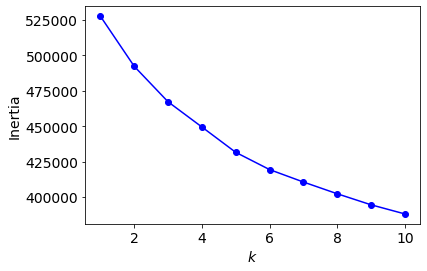

In [140]:
plt.plot(range(1, 11), k_mnist_inertias, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

In [146]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=1)
kmeans.fit(X_mnist)
silhouette_score(X_mnist, kmeans.labels_)

0.07206098052681294

In [150]:
silhouette_scores = [silhouette_score(X_mnist, model.labels_)
                     for model in k_mnist_models[1:]]

In [160]:
silhouette_scores

[0.09083133001699314,
 0.058347152247550764,
 0.06086922515874289,
 0.07206098052681294,
 0.06942294848647053,
 0.07594181378668804,
 0.07804424199970951,
 0.06226382764300887,
 0.06208235086437587]

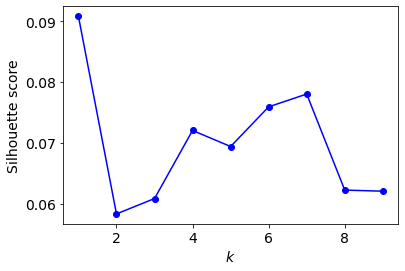

In [161]:
plt.plot(range(1, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [163]:
plot_decision_boundaries(k_mnist_models[4-1], X_mnist)
plt.title('k=4')
plt.show()

ValueError: ignored

# Beyond the lectures

In this section, we present a few advanced topics, some of which you may want to come back to after we have seen classification algorithms.

## Application: Clustering for Preprocessing

Clustering can be used as a preprocessing step for supervised training.

Here, we explore this application on the digits dataset, the small brother of the MNIST dataset.

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, t_digits = load_digits(return_X_y=True)
X_train, X_test, t_train, t_test = train_test_split(X_digits, t_digits, random_state=42)

In [ ]:
# Let's see what we have
print('Labels:', np.unique(t_digits))
print('Size of datasets (train; test):', X_train.shape, X_test.shape)

Let's fit a LogisticRegression model

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, t_train)

The accuracy on the test set is

In [ ]:
log_reg_score = log_reg.score(X_test, t_test)
log_reg_score

Now let's use a K-means algorithm as a pre-processing pipeline.

This means that instead of using the full dataset of size `X_train.shape`, we will used the transformed version, with a reduced number of features, corresponding to the distance to each cluster.

In [ ]:
# Let's say we want 50 clusters
pp_Kmeans = KMeans(n_clusters=50, random_state=42)

X_reduced_KM = pp_Kmeans.fit_transform(X_train)

print(X_train.shape, X_reduced_KM.shape)

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", pp_Kmeans),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, t_train)

And compute the test accuracy

In [ ]:
pipeline_score = pipeline.score(X_test, t_test)
pipeline_score

We see that the error rate on the test set dropped by a factor of

In [ ]:
1 - (1-pipeline_score)/(1-log_reg_score)

## Application: Clustering for Semi-Supervised Learning

Imagine the situation in which you don't any labels, so you decide to label by hand a few of them. Let's do this with the digits dataset:

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, t_digits = load_digits(return_X_y=True)
X_train, X_test, t_train, t_test = train_test_split(X_digits, t_digits, random_state=42)

We choose the first 50 (random choice)

In [ ]:
n_labeled = 50

X_representative_digits = X_train[:n_labeled]

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(n_labeled // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

and label them by hand. 

In [ ]:
t_representative_digits = t_train[:n_labeled]
t_representative_digits

And now we use this to train our dataset. Let's fit and see the performance of our model on the test data

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_representative_digits, t_representative_digits)
log_reg.score(X_test, t_test)

The accuracy is pretty low, but is reasonable given that we're training in only 50 instances.

One way we can improve this is by picking better digits to label. If we pick good representatives of our data, our model will have more information to learn from. 

We can do this by clustering our digits, and picking one representative from each cluster.

In [ ]:
k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

# Keep instance closer to each cluster centrer
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now, we didn't pick representative digits at random, but we picked the ones closer to each clusters centroid.

In [ ]:
plt.figure(figsize=(8, 3))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

We can proceed and label these 50 by hand

In [ ]:
t_representative_digits = t_train[representative_digit_idx]
t_representative_digits

And train a model.

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, t_representative_digits)
log_reg.score(X_test, t_test)

The accuracy on the test set is much better! And we're still training on only 50 instances, the difference is that we picked correctly the representatives.

But we can use our clustering algorithm to go even further. Let's replicate the label of each representative to the rest of the instances of that cluster:

In [ ]:
#empty vector of the right shape
t_train_propagated = np.empty(len(X_train), dtype=np.int32)

#lets iterate over the clusters
for i in range(k):
    #the predicted cluster for each instance in the training set is saved in kmeans.labels_
    t_train_propagated[kmeans.labels_==i] = t_representative_digits[i]

And now, let's train with this new automatically labelled **full** dataset

<img width=600px src="https://media.giphy.com/media/xUA7ba9aksCuKR9dgA/giphy.gif">

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, t_train_propagated)
log_reg.score(X_test, t_test)

The score got even better! This technique is called semi-supervised learning: An unsupervised learning technique is used to propagate labels on the training set, which is used as input for a supervised model.

## Train a SVC on the reduced faces dataset

In [ ]:
# Read data
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [ ]:
# Define feature matrix (X)
X = lfw_people.data

# Number of features
n_features = X.shape[1]

# The label to predict (t) is the id of the person (a number from 0 to 6)
t = lfw_people.target

# In case you want to match this with the actual name of the person, 
# the information comes packed in the `target_names` atrribute
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('A dataset with {} instances of {} features and {} classes.'.format(len(X), n_features, n_classes))

In [ ]:
# Who are these people?
target_names

In [ ]:
# Is the dataset balanced?
for i in range(len(target_names)):
    print(target_names[i],':',sum(t == i))

In [ ]:
#lets plot a few of examples
n_pics_per_person = 6

n_cols = n_pics_per_person
n_rows = len(target_names)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.6*n_cols, 2*n_rows))

for i in range(len(target_names)):
    # Select instances of that class
    Xi = X[t == i]
    # Randomly select n_pics_per_person
    idj = np.random.choice(len(Xi), size=n_pics_per_person, replace=False)
    
    for j, jj in enumerate(idj):
        axs[i, j].imshow(Xi[jj].reshape(50, 37), cmap='gray')
        axs[i, j].axis('off')
    axs[i, 0].set_title(target_names[i])

**Complete the following cell**

In [ ]:
# Train-test split
X_train, X_test, t_train, t_test = train_test_split(...)

# Let's see the shape of the resulting training set
print(X_train.shape)

**Train a SVC on a dataset with reduced dimensionality**

* Complete the following code.
* What criterion would you use to choose `d` (see notebook above)

In [ ]:
# Train a SVC with and without dimensionality reduction.
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

d = ...

# Instantiate a pipeline including the PCA step
pipe = make_pipeline(PCA(n_components=d), SVC())
# and a SVC _without_ dimensionality reduction
svc =  SVC()

# Train both algorithms
svc.fit(..., ...)
pipe.fit(..., ...)

**Compare the score of both predictors**

* Use the test set.
* What conclusion can you reach? 

In [ ]:
pipe.score(..., ...), svc.score(..., ...)

## Other algorithms

There are many methods for Dimensionality Reduction and Clustering. PCA and K-Means are by far the most populars ones, but there are many others. 

Try other algorithms on the datasets presented in this notebook. 

Additional **dimensionality reduction** algorithms implemented in scikit-learn are:

* Random projections (implmented in the [sklearn.random_projection](https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20random#module-sklearn.random_projection) module).

* Isomaps ([sklearn.manifold.Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)).

* MultiDimensional Scaling (MDS; [sklearn.manifold.MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)).

There is also a vast set of **clustering** algorithms implemented in the [clustering](https://scikit-learn.org/stable/modules/clustering.html) module.

![Comparison of Algorithms](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)